# Meme Humour Classification: Deep-learning-based Multi-modal Fusion with Humor Semantics

## 1. import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys

# TODO: change this to the path to your homework folder
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive','EECS487Project')
print(os.listdir(GOOGLE_DRIVE_PATH))

os.chdir(GOOGLE_DRIVE_PATH)

['__pycache__', '.ipynb_checkpoints', 'df_val_pickle', 'df_test_pickle', 'df_train_pickle', 'image', 'text', 'label', 'clip', 'test result.xlsx']


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.4 MB/s eta 0:00:00


In [ ]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

# import directories
import image
from text import text_embedding

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 2. Load dataset

In [ ]:
# load labels_pd_pickle
train = pd.read_pickle('df_train_pickle')
val = pd.read_pickle('df_val_pickle')
test = pd.read_pickle('df_test_pickle')
# show first 5 rows
val['sarcastic']

0          little_sarcastic
1          little_sarcastic
2             not_sarcastic
3            very_sarcastic
4             not_sarcastic
               ...         
1495       little_sarcastic
1496       little_sarcastic
1497    extremely_sarcastic
1498       little_sarcastic
1499          not_sarcastic
Name: sarcastic, Length: 1500, dtype: object

In [ ]:
def basic_collate_fn_all(batch):
    """Collate function for basic setting."""
    # texts
    text = torch.stack(tuple(item['text'].to('cuda') for item in batch)).to('cuda')
    # image
    image = torch.stack(tuple(item['image_embedding'] for item in batch)).to('cuda')
    # clip
    clip = torch.stack(tuple(item['clip'] for item in batch)).to('cuda')
    # labels
    labels = [item['rating'][3] for item in batch]
    return text, image, clip, labels

In [ ]:
from torch.utils.data import Dataset
class dataloader(Dataset):
    """Generate data loader."""
    def __init__(self, train,file1,file2, file3):
        super().__init__()
        image_embedding = torch.load(file1)
        text_embedding = torch.load(file2)
        clip_embedding = torch.load(file3).float()
        self.items = []
        train['humour'] = train['humour'].map({'hilarious': 1, 'very_funny': 1, 'funny': 1, 'not_funny': 0})
        train['sarcastic'] = train['sarcastic'].map({'extremely_sarcastic':1, 'very_sarcastic': 1, 'little_sarcastic': 1, 'not_sarcastic': 0})
        train['offensive'] = train['offensive'].map({'hateful_offensive':1, 'very_offensive': 1, 'slight': 1, 'not_offensive': 0})
        train['motivational'] = train['motivational'].map({'motivational': 1, 'not_motivational': 0})
        train['overall_sentiment'] = train['overall_sentiment'].map({'very_positive':1,'positive': 1, 'very_negative':0, 'negative': 0, 'neutral': 1})
        for index, row in train.iterrows():
            self.items.append({
                'text': text_embedding[index],
                'image_embedding': image_embedding[index].squeeze(),
                'clip': clip_embedding[index],
                'rating': [row['humour'],row['sarcastic'],row['offensive'],row['motivational'],row['overall_sentiment']]
                #'rating': [row['humour'],row['sarcastic'],row['offensive'],row['overall_sentiment']]
            })
        self.labels = [item['rating'][1] for item in self.items]  # define labels as a list of ratings
  
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, index):
        return self.items[index]
      
    def get_labels(self):
        return self.labels;


In [ ]:
train_data = dataloader(train,'image/image_embedding_VGG_finetuned_enhanced.pt','text/train_text_embed_ft', 'clip/clip_embedding_train.pt')
val_data = dataloader(val,'image/val_embedding_VGG_finetuned.pt','text/val_text_embed_ft', 'clip/clip_embedding_val.pt')

In [ ]:
!pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
train_loader = DataLoader(train_data, batch_size=32, collate_fn=basic_collate_fn_all, shuffle=True)
#dev_loader = DataLoader(val_data, batch_size=32, collate_fn=basic_collate_fn_all, shuffle=True)
#train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=32, collate_fn=basic_collate_fn_all)
#print(len(train_loader.dataset))

dev_loader = DataLoader(val_data, batch_size=32, collate_fn=basic_collate_fn_all, shuffle=True)

In [ ]:
# #s={1:0,0:0}
# for _, (a,b,c,d) in enumerate(train_loader):
#   print(b)
#   break
# #  for item in c:
# #    if item[3]==0:
# #      s[0] += 1
# #    else:
# #      s[1] += 1
# #s
# image_embedding = torch.load('image/image_embedding_VGG_finetuned_enhanced.pt')
# text_embedding = torch.load('text/train_text_embedding_R.pt')
# clip_embedding = torch.load('clip/clip_embedding_train.pt')
# print(image_embedding.dtype)
# print(clip_embedding.dtype)
# clip_embedding = clip_embedding.float()
# print(clip_embedding.dtype)


# 3. CLIP Embedding

## 4. Train Model

In [ ]:
# transformer for multi-tasking

import torch
import torch.nn as nn
import torch.optim as optim

class TransformerClassifier(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(TransformerClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        
        self.fc2 = nn.Linear(800, 512)

        self.fc3 = nn.Linear(1024, 512)
        # for attention
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(512,nhead=8),2
        )
        # for concatenation
        #self.encoder = nn.TransformerEncoder(
        #    nn.TransformerEncoderLayer(1024,nhead=8),2
        #)
        self.dropout = nn.Dropout(0.3)
        self.fc4 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()
        #self.attention = nn.Linear(1024, 1024)
        #self.fc5 = nn.Linear(1024, 4)
        
    def forward(self, x,y,z):
        # res = self.encoder(y)
        
        # attention
        x = self.fc1(x.squeeze())
        y = self.fc2(y)
        z = self.fc3(z.squeeze())
        x = self.encoder(torch.stack((x,y,z)))
        x = x.max(dim = 0)[0]
        #print("x: {}".format(x.size()))
        x = self.dropout(x)
        res = self.fc4(x)
        res = self.sigmoid(res)
        
        '''
        # concatenation
        x = self.fc1(x.squeeze())
        y = self.fc2(y.squeeze())
        z = torch.cat((x, y), dim=1)
        #print("z: {}".format(z.size()))
        z = self.encoder(z.unsqueeze(0)).squeeze(0)
        z = self.dropout(z)
        #print("z: {}".format(z))
        res = self.fc4(z)
        '''

        #print("res: {}".format(res.size()))
        return res


In [ ]:
def train_tf(model, train_loader, optimizer, epochs=5):
    train_loss, train_loss_ind, val_loss, val_loss_ind = [], [], [], []
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for idx, (text, image, clip, target) in enumerate(train_loader):
            optimizer.zero_grad()
            target = torch.Tensor(target).to('cuda')
            output = model(text,image,clip).squeeze()
            loss = nn.CrossEntropyLoss()(output,target)
            loss.backward()
            optimizer.step()
        if epoch%1 == 0:
          print('Epoch: {} Loss: {}'.format(
                    epoch, 
                    loss.item()))
        train_loss_ind.append(epoch)
        val_loss_ind.append(epoch)
        train_loss.append(loss.item())
        model.eval()
        acc = torch.Tensor([0]).to('cuda')
        with torch.no_grad():
          for idx, (text, image, clip, target) in enumerate(dev_loader):
              target = torch.Tensor(target).squeeze().to('cuda')
              output = model(text,image,clip).squeeze()
              loss = nn.CrossEntropyLoss()(output,target)
              acc += sum(torch.round(output) == target) /1500
        if epoch%1 == 0:
          print('Epoch',epoch,'val loss',loss.item(),'val acc',acc)
        val_loss.append(loss.item())
    stats = {'train_loss': train_loss,
          'train_loss_ind': train_loss_ind,
          'val_loss': val_loss,
          'val_loss_ind': val_loss_ind,
          'accuracy': acc,
    }
    return model,stats

In [ ]:
import matplotlib.pyplot as plt
from torch import optim

In [ ]:
def plot_loss(stats):
    """Plot training loss and validation loss."""
    plt.plot(stats['train_loss_ind'], stats['train_loss'], label='Training loss')
    plt.plot(stats['val_loss_ind'], stats['val_loss'], label='Validation loss')
    plt.legend()
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.show()

learning rate: 0.0001, weight decay: 0, hidden layer: 512, layer number: 2
Epoch: 0 Loss: 3.178154230117798
Epoch 0 val loss -0.0 val acc tensor([0.9533], device='cuda:0')
Epoch: 1 Loss: -0.0
Epoch 1 val loss 6.664411544799805 val acc tensor([0.9533], device='cuda:0')
Epoch: 2 Loss: 6.356154441833496
Epoch 2 val loss 6.6644086837768555 val acc tensor([0.9533], device='cuda:0')
Epoch: 3 Loss: 3.1780314445495605
Epoch 3 val loss 6.66441011428833 val acc tensor([0.9533], device='cuda:0')
Epoch: 4 Loss: -0.0
Epoch 4 val loss 6.664409637451172 val acc tensor([0.9533], device='cuda:0')
Epoch: 5 Loss: -0.0
Epoch 5 val loss -0.0 val acc tensor([0.9533], device='cuda:0')
Epoch: 6 Loss: 6.356117248535156
Epoch 6 val loss 3.3322041034698486 val acc tensor([0.9533], device='cuda:0')
Epoch: 7 Loss: 6.35615348815918
Epoch 7 val loss 3.3322060108184814 val acc tensor([0.9533], device='cuda:0')
Epoch: 8 Loss: 6.356077671051025
Epoch 8 val loss 6.664409637451172 val acc tensor([0.9533], device='cuda:0'

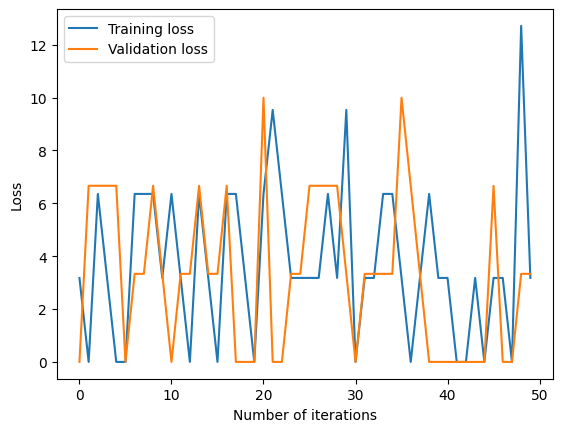

In [ ]:
for lr in [0.0001]:
  for wd in [0]:
    for hd in [512]:
      for ly in [2]:
        model_tf = TransformerClassifier(hd,1,ly).to('cuda')
        optimizer = optim.Adam(model_tf.parameters(), lr=lr,weight_decay=wd)
        print('learning rate: {}, weight decay: {}, hidden layer: {}, layer number: {}'.format(lr, wd, hd, ly))
        model, stats = train_tf(model_tf,train_loader,optimizer,50)
        plot_loss(stats)

In [ ]:
for lr in [0.001,0.0001]:
  for wd in [0,0.00001]:
    for hd in [128,256]:
      for ly in [2,4]:
        model_tf = TransformerClassifier(hd,1,ly).to('cuda')
        optimizer = optim.AdamW(model_tf.parameters(), lr=lr,weight_decay=wd)
        print(lr,wd,hd,ly)
        model, stats = train_tf(model_tf,train_loader,optimizer,50)
        plot_loss(stats)

## 5. Test Model

In [ ]:
test = pd.read_csv('label/test_gold.csv')
test['humour'] = test['humour'].map({'hilarious': 1, 'very_funny':1, 'funny': 1, 'not_funny': 0})
test['sarcastic'] = test['sarcastic'].map({'extremely_sarcastic':1, 'very_sarcastic': 1, 'little_sarcastic': 1, 'not_sarcastic': 0})
test['offensive'] = test['offensive'].map({'hateful_offensive':1, 'very_offensive': 1, 'slight': 1, 'not_offensive': 0})
test['motivational'] = test['motivational'].map({'motivational': 1, 'not_motivational': 0})
test['overall_sentiment'] = test['overall_sentiment'].map({'very_positive':1,'positive': 1, 'very_negative':0, 'negative': 0, 'neutral': 1})

In [ ]:
image_embedding = torch.load('image/test_embedding_VGG_finetuned.pt').squeeze().to('cuda')
text_embedding = torch.load('text/test_text_embedding_R.pt')
clip_embedding = torch.load('clip/clip_embedding_test.pt')
text = torch.stack(tuple(item for item in text_embedding)).to('cuda')
result = torch.round(model.forward(text,image_embedding)).to('cuda')
print(torch.Tensor(test['humour']))
print(result[:, 0])

TypeError: ignored

In [ ]:
#!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score

tensor(0.5900, device='cuda:0')

In [ ]:
def get_test(model):
  image_embedding = torch.load('image/test_embedding_VGG_finetuned.pt').squeeze().to('cuda')
  text_embedding = torch.load('text/test_text_embedding_R.pt')
  text = torch.stack(tuple(item for item in text_embedding)).to('cuda')
  result = torch.round(model.forward(text,image_embedding)).to('cuda')
  print("Humour test:",multiclass_f1_score(result[:,0], torch.Tensor(test['humour']).to('cuda'), num_classes=4,average='weighted'))
  print("Sarcastic test:", multiclass_f1_score(result[:,1], torch.Tensor(test['sarcastic']).to('cuda'), num_classes=4,average='weighted'))
  print("Offensive test:", multiclass_f1_score(result[:,2], torch.Tensor(test['offensive']).to('cuda'), num_classes=4,average='weighted'))
  #print("Moltivational test:",sum(torch.Tensor(test['motivational']).to('cuda')==result[:,3])/1500)
  print("Overall test:", multiclass_f1_score(result[:,3], torch.Tensor(test['overall_sentiment']).to('cuda'), num_classes=3,average='weighted'))

In [ ]:
from sklearn.metrics import f1_score
def get_test_2(model):
  image_embedding = torch.load('image/test_embedding_VGG_finetuned.pt').squeeze().to('cuda')
  text_embedding = torch.load('text/test_text_embed_ft')
  clip_embedding = torch.load('clip/clip_embedding_test.pt').float()
  text = torch.stack(tuple(item for item in text_embedding)).to('cuda')
  result = torch.round(model.forward(text,image_embedding, clip_embedding)).cpu().detach().numpy()
  print("-1: {}".format(sum(result[:,0]==-1)))
  print("0: {}".format(sum(result[:,0]==0)))
  print("1: {}".format(sum(result[:,0]==1)))
  print("2: {}".format(sum(result[:,0]==2)))
  print("3: {}".format(sum(result[:,0]==3)))
  print("4: {}".format(sum(result[:,0]==4)))
  print("5: {}".format(sum(result[:,0]==5)))
  #print("Humour test:",f1_score( torch.Tensor(test['humour']).cpu().numpy(),result[:,0], average='weighted'))
  # print("Sarcastic test:",f1_score(torch.Tensor(test['sarcastic']).cpu().numpy(),result[:,0],  average='weighted'))
  #print("Offensive test:", f1_score( torch.Tensor(test['offensive']).cpu().numpy(), result[:,0],average='weighted'))
  print("Moltivational test:",f1_score( torch.Tensor(test['motivational']).cpu().numpy(), result[:,0],average='weighted'))
  #print("Overall test:", f1_score( torch.Tensor(test['overall_sentiment']).cpu().numpy(), result[:,0],average='weighted'))

In [ ]:
get_test_2(model)

-1: 0
0: 1500
1: 0
2: 0
3: 0
4: 0
5: 0
Moltivational test: 0.9800447427293065


In [ ]:
(0.4587+0.1660+0.6093+0.8607)/4

0.523675

In [ ]:
one = 0
zero = 0
other = 0
for _, (a,b,d) in enumerate(train_loader):
  for c in d:
    if c[1] == 0:
      zero += 1
    elif c[1] == 1:
      one += 1
    else:
      other +=1
print(zero,one,other)
one = 0
zero = 0
other = 0
for _, (a,b,d) in enumerate(dev_loader):
  for c in d:
    if c[1] == 0:
      zero += 1
    elif c[1] == 1:
      one += 1
    else:
      other +=1
print(zero,one,other)

3871 1759 1370
804 388 308
